<a href="https://colab.research.google.com/github/gravityGao/book/blob/master/breath_filter_discard_2s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install biosignalsnotebooks

In [ ]:
import biosignalsnotebooks as bsnb

# Scientific packages
import numpy as np
from numpy import linspace, diff, zeros_like, arange, array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/BreathPulse/24Fall/ValidateSensor_Data/user1_validate_bitalino2024-08-27 17-34-22.txt'
# Sampling frequency of acquired data
fs = 1000

# Signal Samples
signal = np.genfromtxt(file_path)

# signal = signal[:,5]

# Generate the time axis of the signal given its sampling frequency
time = bsnb.generate_time(signal, fs)
time = np.array(time)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


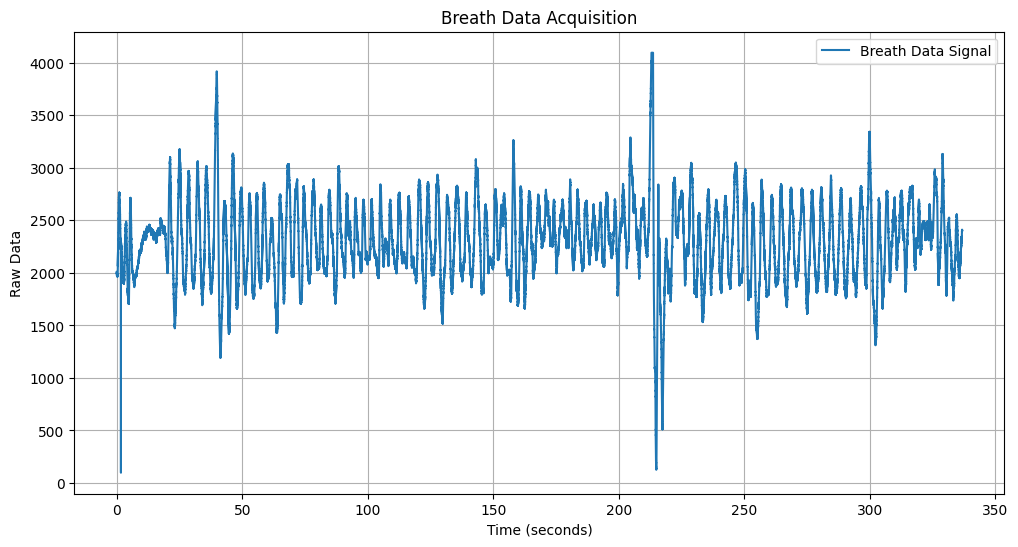

In [ ]:
import matplotlib.pyplot as plt
# Plotting the ECG signal
total_duration = len(signal) / fs
time = np.linspace(0, total_duration, num=len(signal))
plt.figure(figsize=(12, 6))
plt.plot(time, signal, label='Breath Data Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Raw Data')
plt.title('Breath Data Acquisition')
plt.legend()
plt.grid(True)
plt.show()

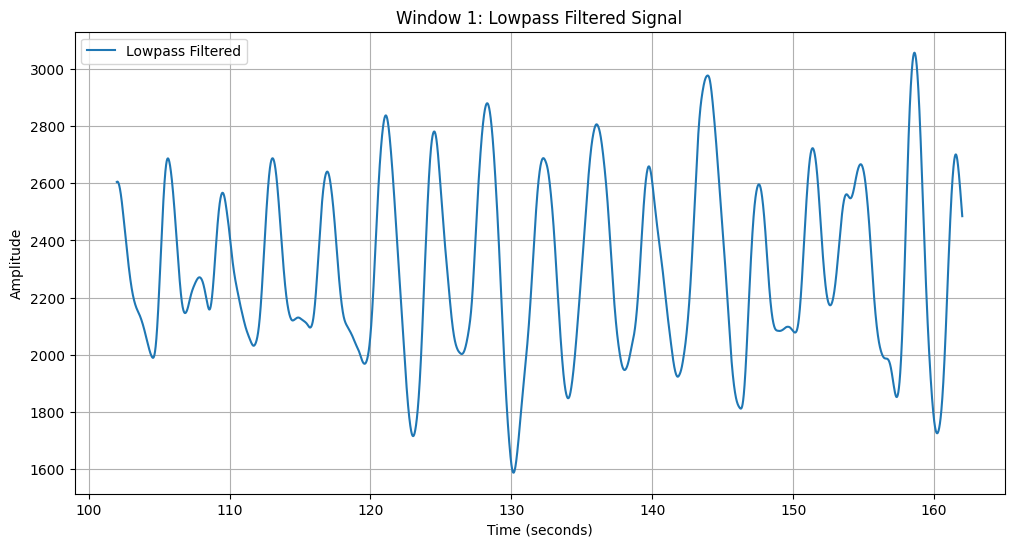

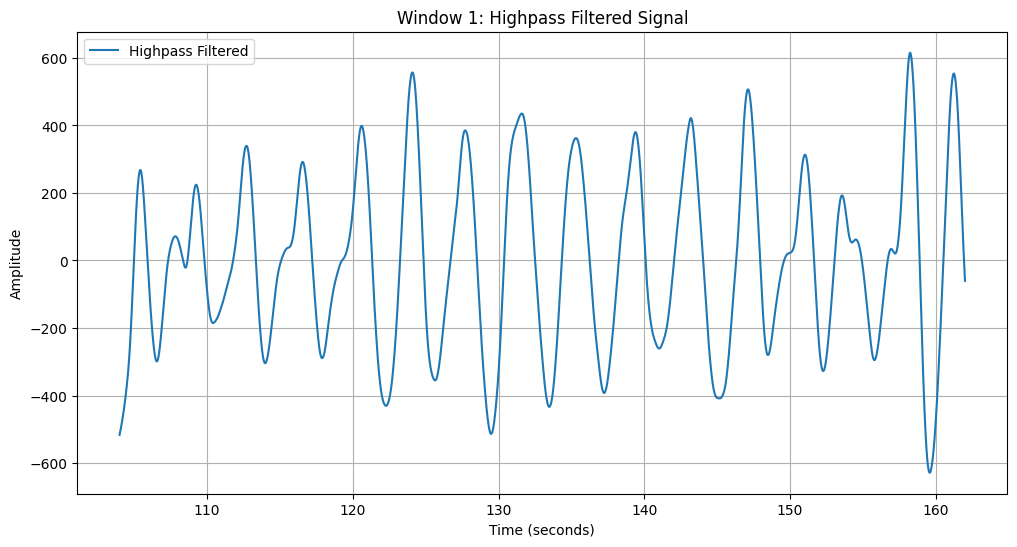

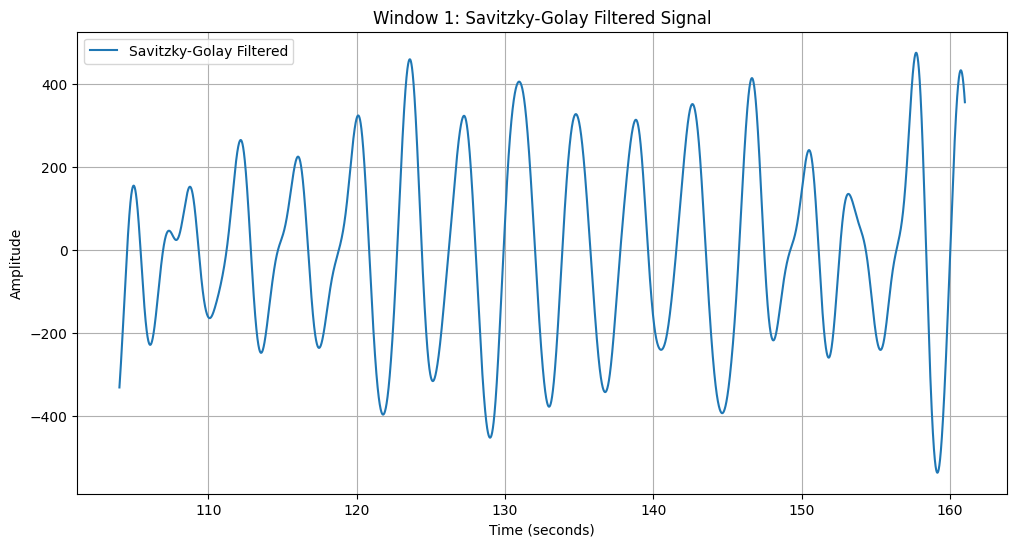

Window 1: Breath Rate = 17
  Peak 0.70
  Peak 0.24
  Peak 0.69
  Peak 1.17
  Peak 1.00
  Peak 1.42
  Peak 1.99
  Peak 1.42
  Peak 1.76
  Peak 1.43
  Peak 1.38
  Peak 1.54
  Peak 1.80
  Peak 1.07
  Peak 0.62
  Peak 2.06
  Peak 1.88


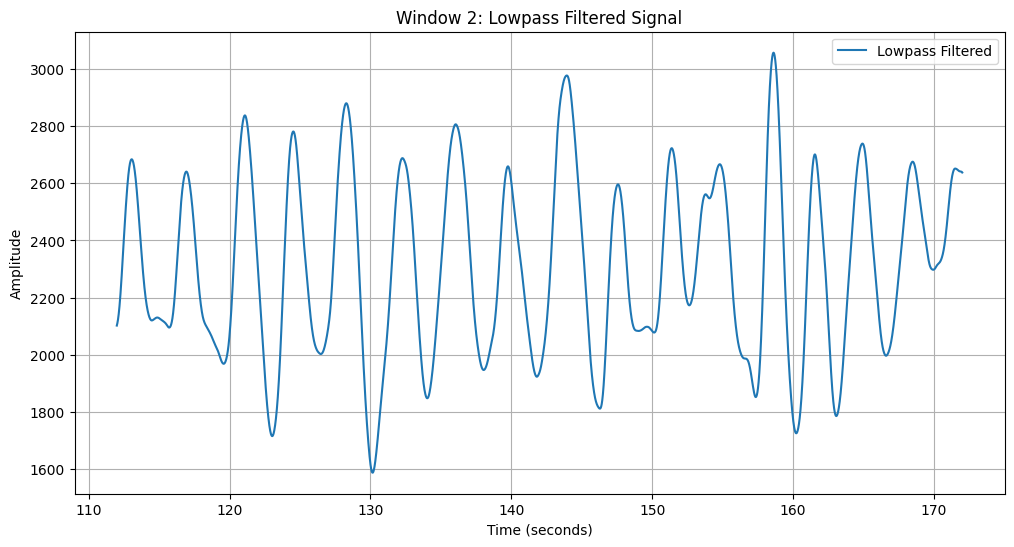

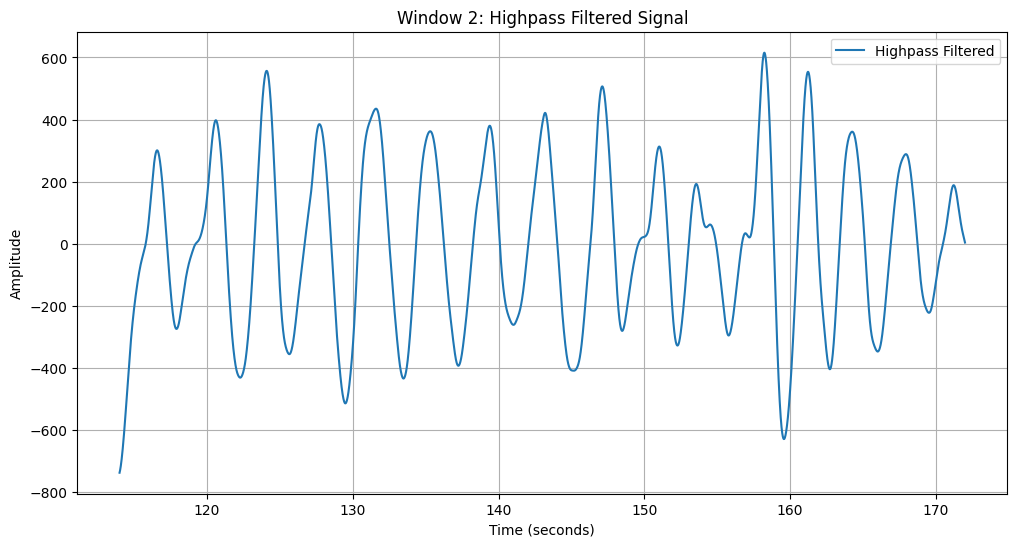

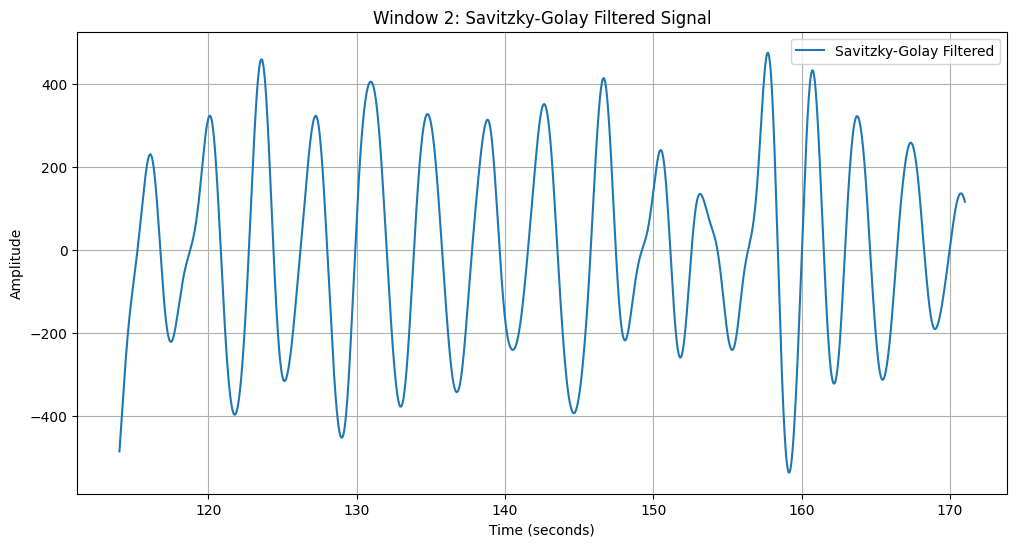

Window 2: Breath Rate = 16
  Peak 0.96
  Peak 1.34
  Peak 1.88
  Peak 1.34
  Peak 1.67
  Peak 1.35
  Peak 1.30
  Peak 1.45
  Peak 1.70
  Peak 1.01
  Peak 0.58
  Peak 1.94
  Peak 1.78
  Peak 1.33
  Peak 1.08
  Peak 0.59


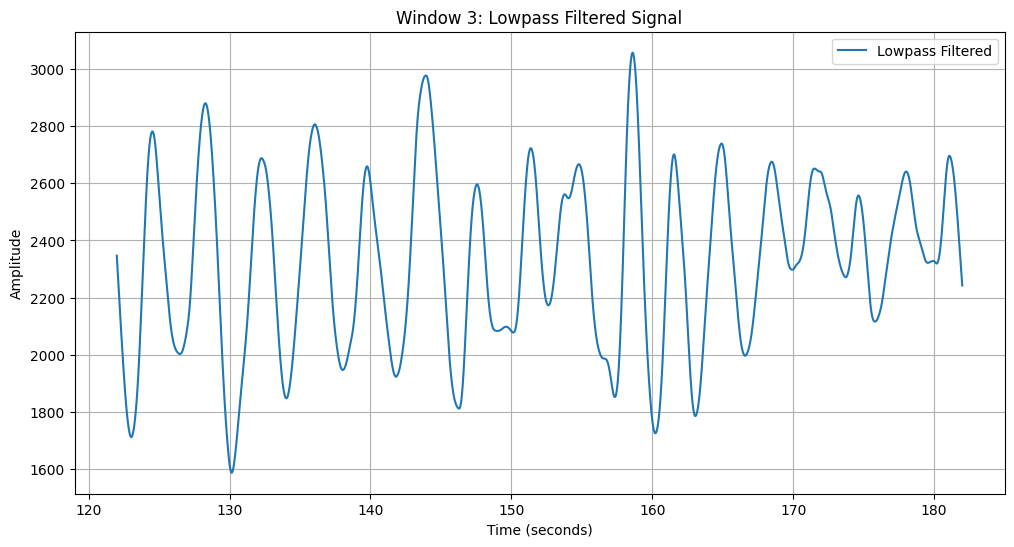

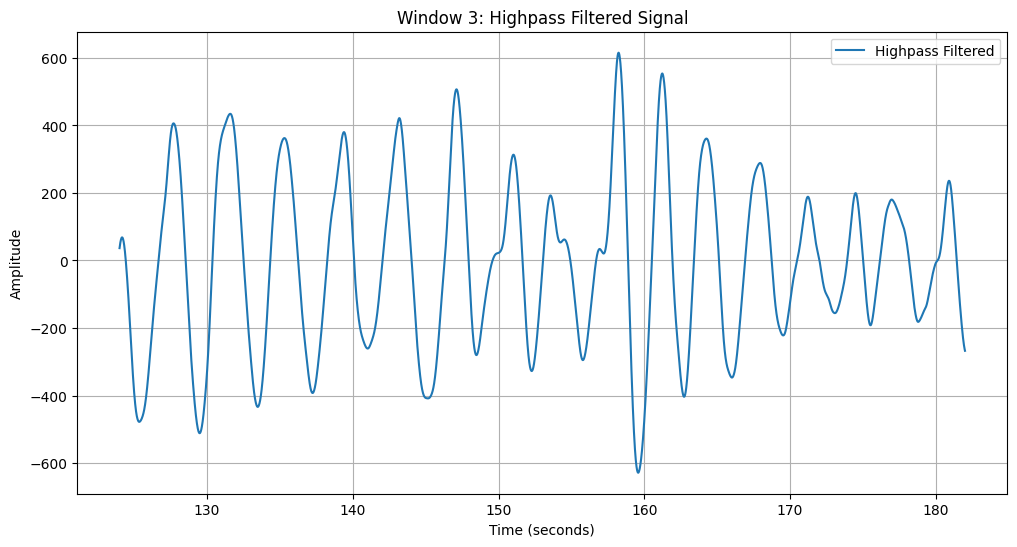

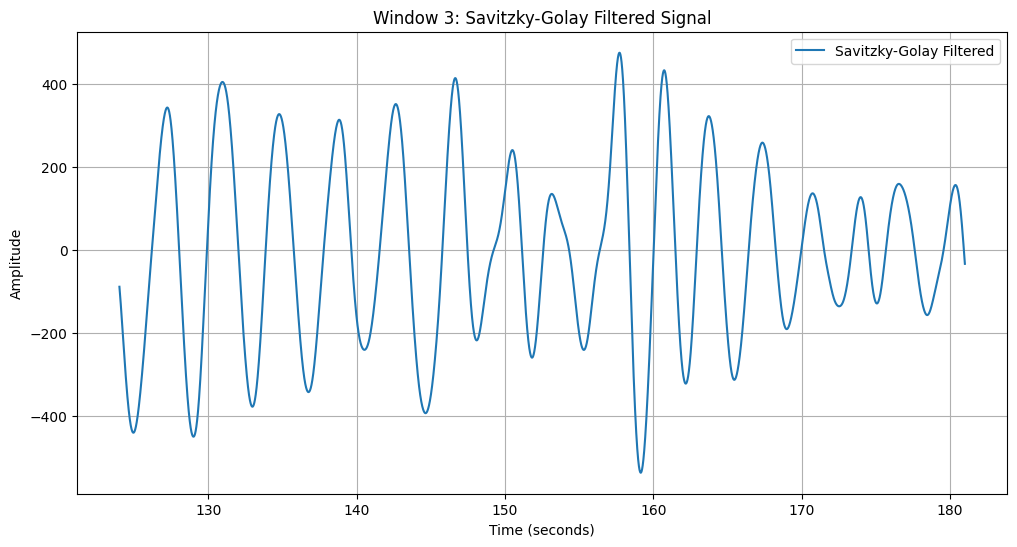

Window 3: Breath Rate = 16
  Peak 1.59
  Peak 1.87
  Peak 1.52
  Peak 1.46
  Peak 1.63
  Peak 1.91
  Peak 1.13
  Peak 0.65
  Peak 2.19
  Peak 2.00
  Peak 1.50
  Peak 1.21
  Peak 0.66
  Peak 0.62
  Peak 0.76
  Peak 0.75


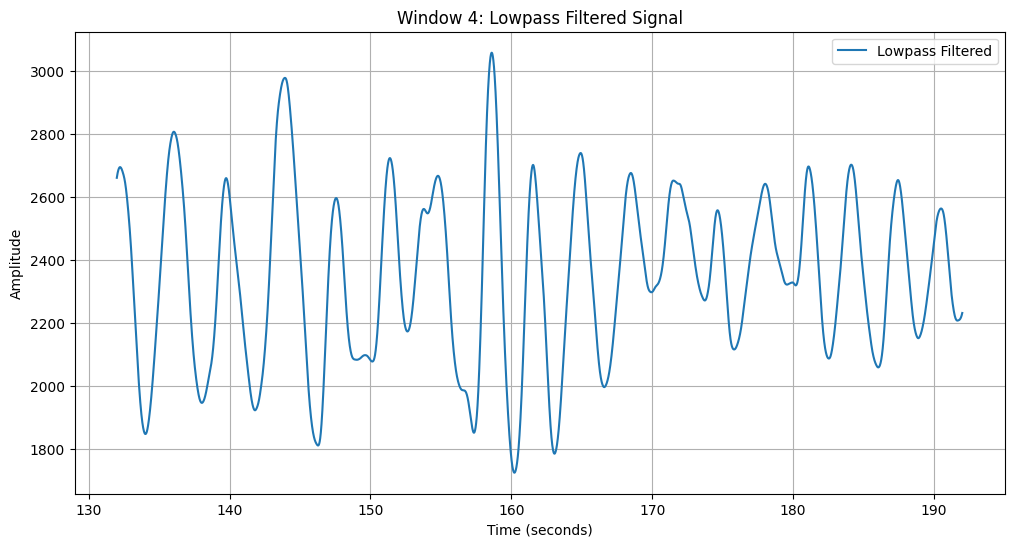

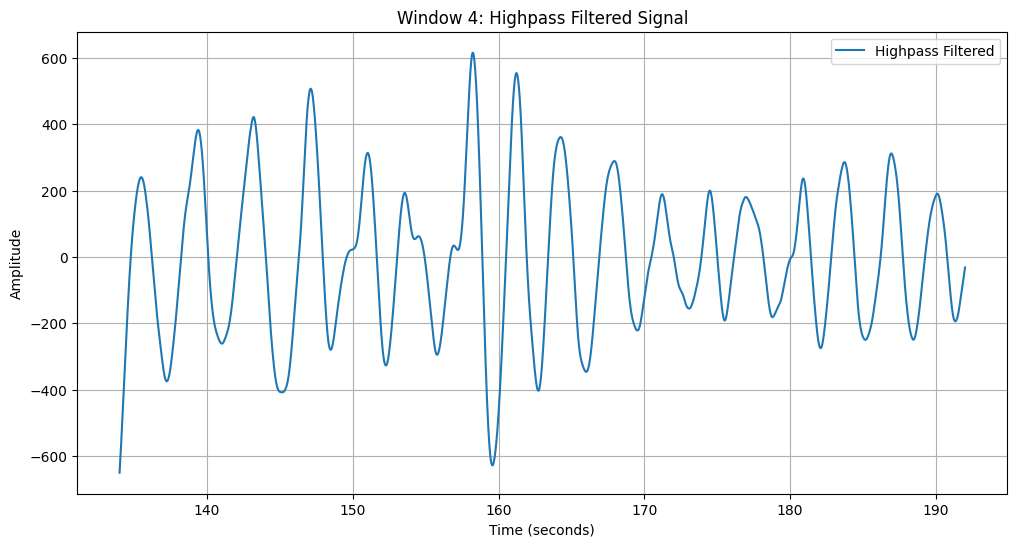

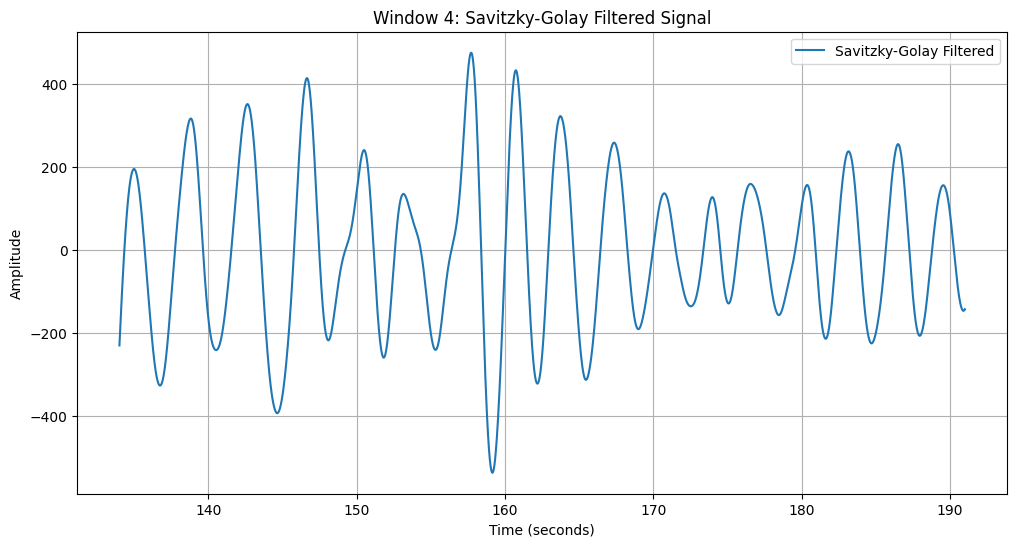

Window 4: Breath Rate = 17
  Peak 0.97
  Peak 1.54
  Peak 1.70
  Peak 1.99
  Peak 1.18
  Peak 0.69
  Peak 2.28
  Peak 2.08
  Peak 1.57
  Peak 1.27
  Peak 0.70
  Peak 0.65
  Peak 0.80
  Peak 0.79
  Peak 1.17
  Peak 1.25
  Peak 0.79


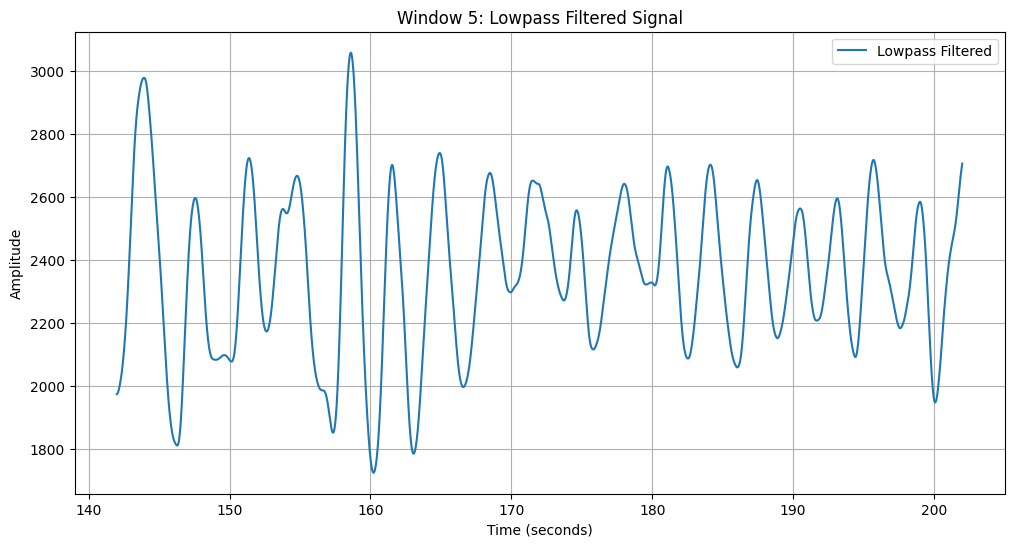

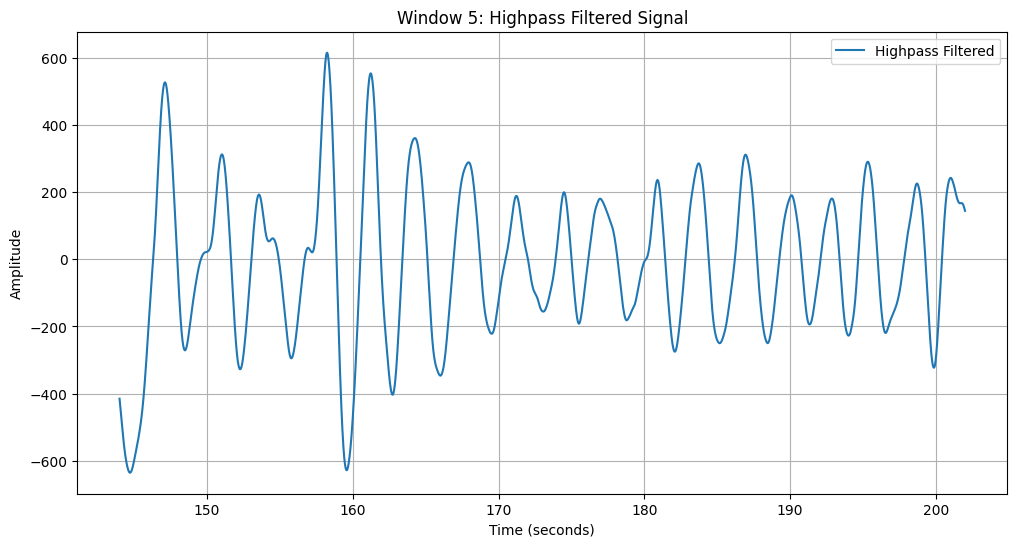

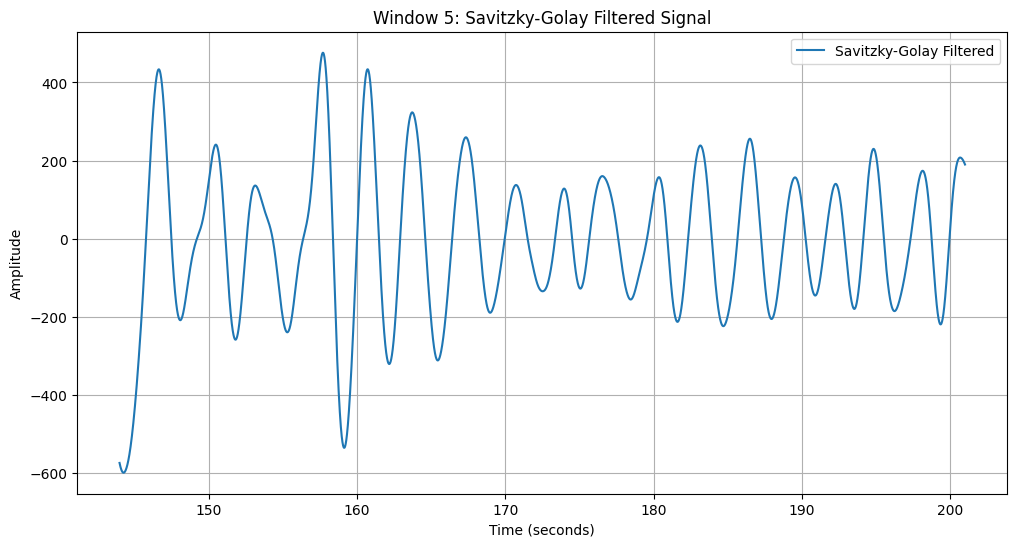

Window 5: Breath Rate = 18
  Peak 2.18
  Peak 1.23
  Peak 0.71
  Peak 2.39
  Peak 2.18
  Peak 1.63
  Peak 1.32
  Peak 0.72
  Peak 0.67
  Peak 0.83
  Peak 0.82
  Peak 1.22
  Peak 1.30
  Peak 0.81
  Peak 0.73
  Peak 1.17
  Peak 0.90
  Peak 1.06


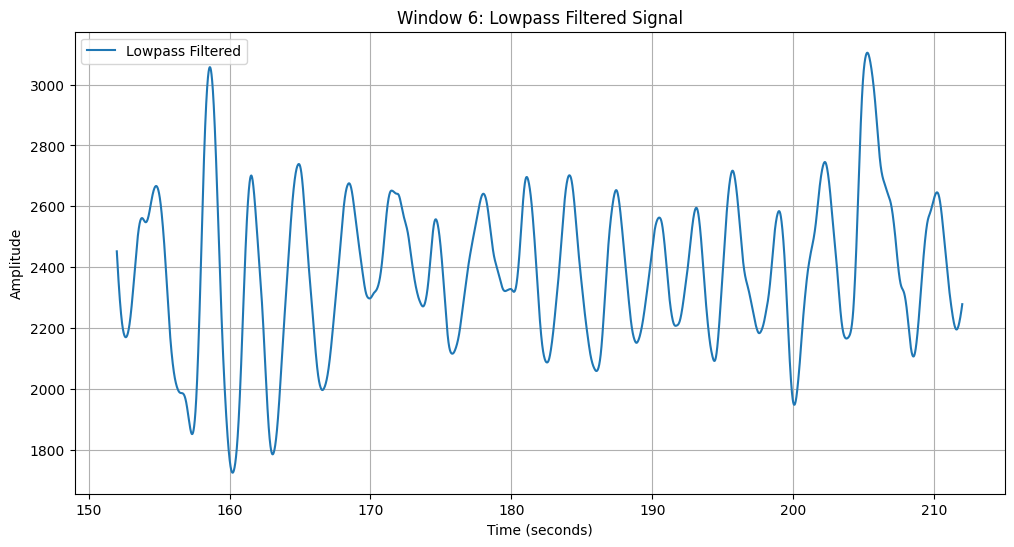

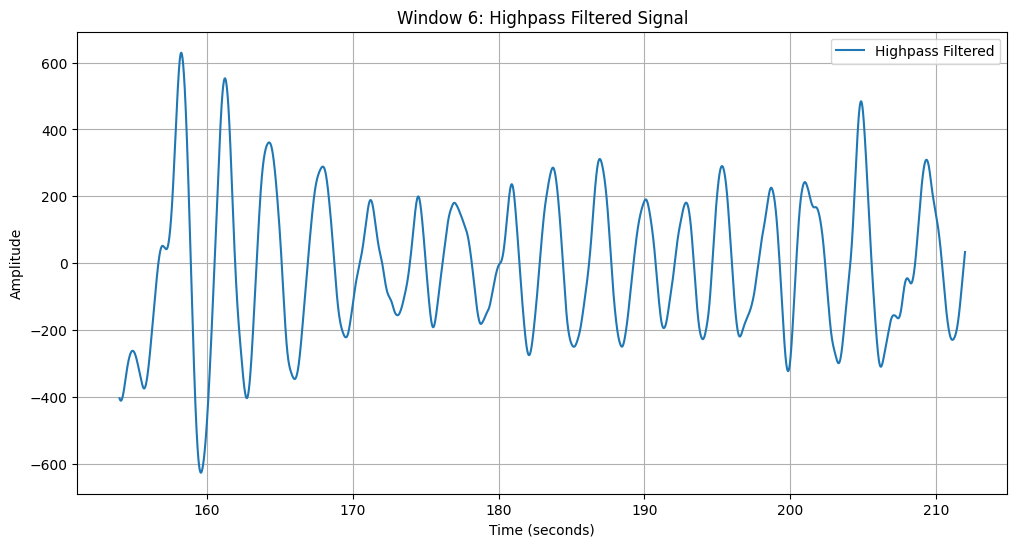

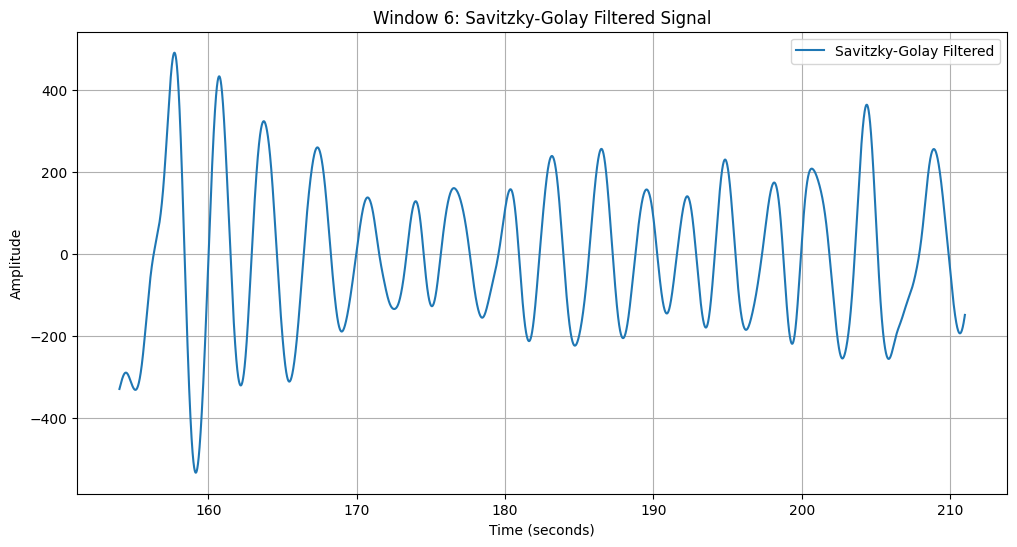

Window 6: Breath Rate = 17
  Peak 2.64
  Peak 2.34
  Peak 1.76
  Peak 1.42
  Peak 0.78
  Peak 0.73
  Peak 0.90
  Peak 0.89
  Peak 1.31
  Peak 1.40
  Peak 0.88
  Peak 0.80
  Peak 1.27
  Peak 0.97
  Peak 1.15
  Peak 1.97
  Peak 1.40


In [ ]:
from scipy.signal import butter, filtfilt, welch, savgol_filter
from scipy.signal import butter, filtfilt, savgol_filter, find_peaks
#
start_time = 100
end_time = 220


start_index = int(start_time * fs)
end_index = int(end_time * fs)


signal_segment = signal[start_index:end_index]
time_segment = np.linspace(start_time, end_time, num=len(signal_segment))

high_freq_components = []
low_freq_components = []
rolling_time_segments = []


# window
window_size = 62 * fs
overlap_size = 52 * fs
step_size = window_size - overlap_size

# discard 2s
discard_seconds = 2
discard_samples = int(discard_seconds * fs)

# moving wimdow
for start in range(0, len(signal_segment) - window_size + 1, step_size):
    window_data = signal_segment[start:start + window_size]
    window_time = time_segment[start:start + window_size]

    # lowpass
    filtered_signal = bsnb.process.lowpass(window_data, f=0.5, fs=fs)
    # remove abnormal peaks
    valid_filtered_signal = filtered_signal[discard_samples:]
    valid_window_time = window_time[discard_samples:]

    # Plot Lowpass Filtered Signal
    plt.figure(figsize=(12, 6))
    plt.plot(window_time[discard_samples:], valid_filtered_signal, label='Lowpass Filtered')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(f'Window {start//step_size + 1}: Lowpass Filtered Signal')
    plt.legend()
    plt.grid(True)
    plt.show()

    # highpass
    more_filtered_signal = bsnb.process.highpass(valid_filtered_signal, f=0.1, fs=fs)

    # remove abnormal peaks
    valid_more_filtered_signal = more_filtered_signal[discard_samples:]
    valid_window_time = valid_window_time[discard_samples:]

    # Plot Highpass Filtered Signal
    plt.figure(figsize=(12, 6))
    plt.plot(valid_window_time, valid_more_filtered_signal, label='Highpass Filtered')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(f'Window {start//step_size + 1}: Highpass Filtered Signal')
    plt.legend()
    plt.grid(True)
    plt.show()


    mov_avg_sig = [np.mean(more_filtered_signal[i:i+fs-1]) for i in range(len(more_filtered_signal)-fs)]

    # Savitzky-Golay
    savgol_signal = savgol_filter(mov_avg_sig, 27, 4)
    # remove abnormal peaks
    valid_savgol_signal = savgol_signal[discard_samples:]
    valid_window_time = valid_window_time[:len(valid_savgol_signal)]

    # Plot Savitzky-Golay Filtered Signal
    plt.figure(figsize=(12, 6))
    plt.plot(valid_window_time, valid_savgol_signal, label='Savitzky-Golay Filtered')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(f'Window {start//step_size + 1}: Savitzky-Golay Filtered Signal')
    plt.legend()
    plt.grid(True)
    plt.show()


    mean_data = np.mean(savgol_signal)
    std_data = np.std(savgol_signal)

    norm_data = (savgol_signal - mean_data) / std_data

    peaks, _ = find_peaks(norm_data, height=(0.2, 4))

    #
    print(f"Window {start//step_size + 1}: Breath Rate = {len(peaks)}")

    for peak in peaks:
        peak_value = norm_data[peak]
        if 0<= peak_value <= 4:
            print(f"  Peak {peak_value:.2f}")

    # 确保信号和时间数组长度一致，截断为最小长度
    min_length = min(len(norm_data), len(valid_window_time))
    norm_data = norm_data[:min_length]
    valid_window_time = valid_window_time[:min_length]

    # save
    high_freq_components.append(norm_data)
    low_freq_components.append(norm_data)
    rolling_time_segments.append(valid_window_time)

# plt.figure(figsize=(12, 6))
# for i in range(len(high_freq_components)):
#     plt.plot(rolling_time_segments[i], high_freq_components[i], label=f'Window {i+1} High Freq Component')

# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.title('After filter')
# plt.legend()
# plt.grid(True)
# plt.show()




峰值个数: 24


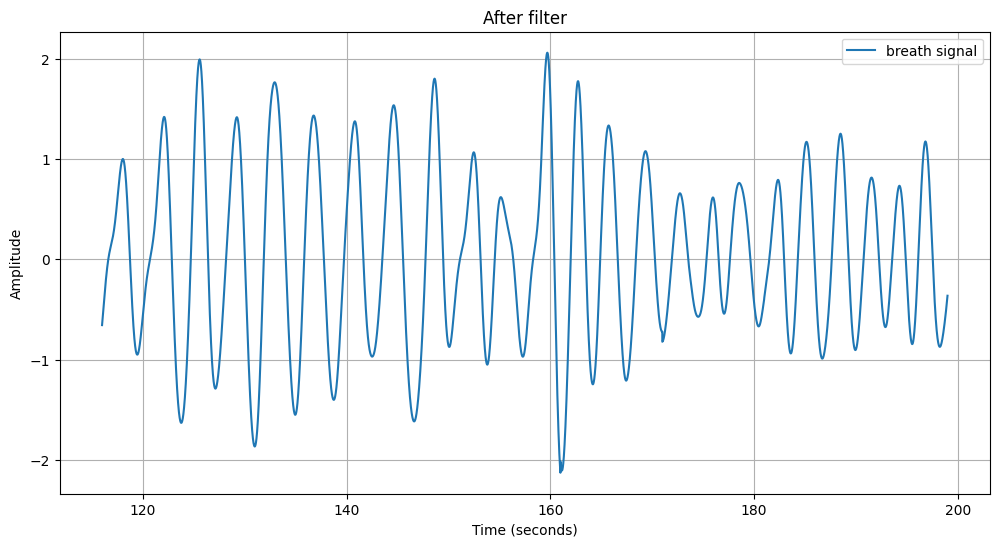

In [ ]:
# all the windows
final_time_segments = []
final_freq_components = []

for i in range(len(rolling_time_segments)):
    if i > 0:
        # remove the overlap window
        non_overlap_index = np.where(rolling_time_segments[i] > rolling_time_segments[i-1][-1])[0]
        if len(non_overlap_index) > 0:
            final_time_segments.append(rolling_time_segments[i][non_overlap_index])
            final_freq_components.append(high_freq_components[i][non_overlap_index])
    else:
        final_time_segments.append(rolling_time_segments[i])
        final_freq_components.append(high_freq_components[i])

# Splice all windows
final_time = np.concatenate(final_time_segments)
final_signal = np.concatenate(final_freq_components)

# discard 2s again
total_discard_samples = discard_samples * len(rolling_time_segments)
final_time = final_time[total_discard_samples:-total_discard_samples]
final_signal = final_signal[total_discard_samples:-total_discard_samples]

peaks, properties = find_peaks(final_signal, height=(0,4))

# 打印所有大于0的峰值及其位置
print(f"峰值个数: {len(peaks)}")
# for peak in peaks:
#     print(f"峰值位置: {peak}, 峰值大小: {signal[peak]}")

# final fig
plt.figure(figsize=(12, 6))
plt.plot(final_time, final_signal, label='breath signal')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('After filter')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# from scipy.signal import butter, filtfilt, welch, savgol_filter
# from scipy.signal import butter, filtfilt, savgol_filter, find_peaks
# #
# start_time = 20
# end_time = 160


# start_index = int(start_time * fs)
# end_index = int(end_time * fs)


# signal_segment = signal[start_index:end_index]
# time_segment = np.linspace(start_time, end_time, num=len(signal_segment))

# high_freq_components = []
# low_freq_components = []
# rolling_time_segments = []


# # 滚动窗口参数
# window_size = 60 * fs
# overlap_size = 10 * fs
# step_size = window_size - overlap_size

# # 滚动窗口
# for start in range(0, len(signal_segment) - window_size + 1, step_size):
#     window_data = signal_segment[start:start + window_size]
#     window_time = time_segment[start:start + window_size]

#     # lowpass
#     filtered_signal = bsnb.process.lowpass(window_data, f=0.5, fs=fs)



#     # # #  Savitzky-Golay
#     # savgol_signal = savgol_filter(filtered_signal, 27, 4)


#     mean_data = np.mean(filtered_signal)
#     std_data = np.std(filtered_signal)

#     norm_data = (filtered_signal - mean_data) / std_data

#     # peaks, _ = find_peaks(norm_data, height=(0, 4))

#     # #
#     # print(f"Window {start//step_size + 1}: Breath Rate = {len(peaks)}")

#     # for peak in peaks:
#     #     peak_value = norm_data[peak]
#     #     if 0.5 <= peak_value <= 4:
#     #         print(f"  Peak {peak_value:.2f}")

#     # save
#     high_freq_components.append(norm_data)
#     low_freq_components.append(norm_data)
#     rolling_time_segments.append(window_time[int(fs/2):-int(fs/2)])

# plt.figure(figsize=(12, 6))
# for i in range(len(high_freq_components)):
#     plt.plot(rolling_time_segments[i], high_freq_components[i], label=f'Window {i+1} High Freq Component')

# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.title('After low pass')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# from scipy.fft import fft, rfft, rfftfreq
# fft_vals = rfft(norm_signal)
# fft_freq = rfftfreq(len(norm_signal), 1/fs)
# dominant_frequency = fft_freq[np.argmax(np.abs(fft_vals))]

# print(f"Dominant frequency is: {dominant_frequency:.2f} Hz")

# breath_rate = dominant_frequency * 60

# print(f"Estimated Breath Rate: {breath_rate:.2f} breaths per minute")